In [3]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from collections import Counter

In [4]:
data = pd.read_csv("dataset_final.csv")

In [5]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Freq_Classes_Contract', 'Visits_ActivePeriod']

non_metric_features = data.columns.drop(metric_features).to_list()

In [6]:
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']

In [7]:
attendance_perspective = ['Age', 'Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']

compare = ['UseByTime','Dropout', 'Gender_Female']
df_activities = data[activities].copy()
df_attendance = data[attendance_perspective].copy()

## Removing Outliers using DBSCAN:

 Since we know that our data is highly skewed and contains outliers not removed, we apply a DBSCAN to try to detect the remaining outliers.

 We need to define the parameters of our model ( **ε** and **min_samples**):
 
 -  **min_samples**  is, on a first approach, considered **2 x dim** where dim is the dimension of our metric features;
 - **ε** can be found by ploting a **k-distance graph** (distance to the kth (k = min_samples - 1) nearest neighbor ordered from the largest to the smallest value). The **elbow** of this graph is considered a good value for ε.

In [8]:
##graph

   Looking at the k-distance graph, we select the value **ε= 2.1** as the ideal value (elbow value).

In [9]:
dbscan = DBSCAN(eps=2.25, min_samples = 2 * len(metric_features), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(data[metric_features])

Counter(dbscan_labels)

Counter({0: 14644, -1: 129})

In [10]:
data_c = pd.concat([data, pd.Series(dbscan_labels, name = 'outlier_labels', index = data.index)], axis =1)

We remove the outlier values calculated with DBSCAN and store them for possible future analysis:

In [11]:
data_dbscan_out = data[dbscan_labels == -1]
data = data[dbscan_labels != -1]

In [12]:
data.shape

(14644, 19)

In [13]:
df_attendance = data[attendance_perspective].copy()

## Mean-Shift Clustering

 - Centroid based algorithm that discovers “blobs” in a **smooth density** of samples.   
 -  Works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.



We can estimate the bandwith parameter (Bandwidth used in the flat kernel) directly using the **estimate_bandwith** function from *sklearn.cluster* 

Making **bin_seeding = True** speeds up the algorithm as it needs fewer initializations of seeds.\
 The initial kernel locations are not locations of all points, but rather the location of the discretized version of points, where points are binned onto a grid whose coarseness corresponds to the bandwidth. 

In [14]:
bandwidth = estimate_bandwidth(df_attendance, quantile=0.17, random_state=1, n_jobs=-1)
bandwidth

2.0213006812943033

In [15]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_attendance)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 4


In [16]:
Counter(ms_labels)

Counter({0: 10937, 1: 3343, 2: 349, 3: 15})

As we can see, **Mean Shift Algorithm** is not capable of correctly separating our clients into even clusters.

In [17]:
df_ms = pd.concat([data, pd.Series(ms_labels, index=data.index, name="ms_labels")], axis=1)

We calculate **R2** to get a measure of  the overall proportion of variance explained by the cluster means.

In [18]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_ms[attendance_perspective])  # get total sum of squares
ssw_labels = df_ms[attendance_perspective + ["ms_labels"]].groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3094


## DBSCAN:

**DBSCAN** is used once again, this time to try to cluster our clients into different groups. A smaller **ε** was used as to obtain a bigger number of clusters:

In [19]:
dbscan = DBSCAN(eps = 0.5, min_samples = len(attendance_perspective)*3)
dbscan_labels = dbscan.fit_predict(df_attendance)


dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Counter(dbscan_labels)

Number of estimated clusters : 5


Counter({0: 8388, -1: 4582, 1: 1625, 2: 31, 3: 18})

In [20]:
df_dbscan = pd.concat([data, pd.Series(dbscan_labels, index=data.index, name="dbscan_labels")], axis=1)

In [21]:
sst = get_ss(df_dbscan[attendance_perspective])  # get total sum of squares
ssw_labels = df_dbscan[attendance_perspective + ["dbscan_labels"]].groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2386


DBSCAN struggles with clusters of similar density, which might indicate our data has relatively similar density.

## Gaussian Mixture Model:

**Gaussian Mixture Models** help represent normally distributed subpopulations within an overall population.\
It is a good model to use when clusters have different sizes, shapes, and orientations, so it is a possible approach to comprehend clusters we couldn't find before.

Assumes data is a mixture of Gaussians and is a good model for complex cluster shapes and overlapping clusters.

We need to define the **covariance_type** hyperparameter, that defines the degree of freedom in the shape of each cluster and the **n_components**:

We use **BIC** and **AIC** to define our best parameters, being the smallest value for these metric the best one:

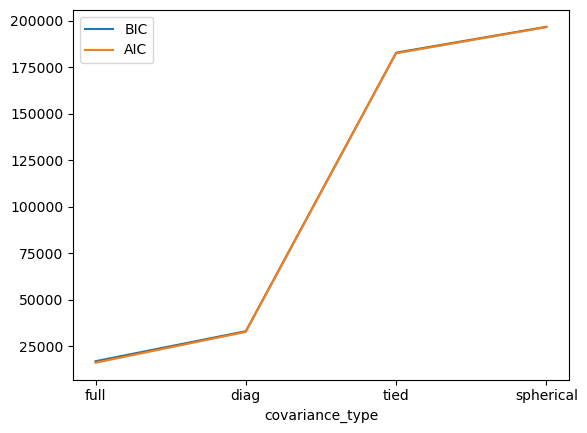

In [22]:
# Selecting covariance type based on AIC and BIC
cov_type = ['full','diag', 'tied', 'spherical']
models = [GaussianMixture(n_components=4, covariance_type=t, n_init=10, random_state=1).fit(df_attendance)
          for t in cov_type]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_attendance) for gmm in models]
aic_values = [gmm.aic(df_attendance) for gmm in models]
plt.plot(cov_type, bic_values, label='BIC')
plt.plot(cov_type, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('covariance_type')
plt.xticks(cov_type)
plt.show()

The smallest metrics ocur for "full"

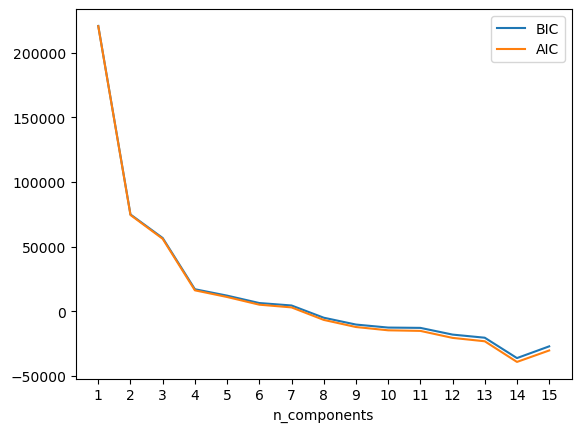

In [23]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_attendance)
          for n in n_components]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_attendance) for gmm in models]
aic_values = [gmm.aic(df_attendance) for gmm in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

Since we are comparing clustering algorithms with 4 clusters and the value *n_componets = 4* has both metrics close to 0, this value is chosen.

The model was not achieving good results using defined values for *tol* (when the change resulting from an iteration is smaller tolerances, the iterations are terminated) and *reg_covar*, smaller values were selected: 

""The **covariance matrix** specifies the spread and orientation of the distribution. Along the diagonal of this covariance matrix we have the variance t  representing the shape (spread) along each of the dimensions. But then we also have the off-diagonal terms (these two thing actually take the same value because this a symmetric matrix) that specify the correlation structure of the distribution.""

""Regularization is applied to the diagnoals to prevent clusters from spreading too much (covariance matrix becoming too large).""

In [24]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='k-means++', random_state=1, max_iter=3000, tol =1*10**-6,reg_covar = 1*10**-7)
gmm_labels = gmm.fit_predict(df_attendance)
labels_proba = gmm.predict_proba(df_attendance)
gmm_labels

array([3, 3, 2, ..., 0, 2, 3])

In [25]:
c= Counter(gmm_labels)
c

Counter({2: 4454, 0: 4378, 3: 3184, 1: 2628})

In [26]:
counter = []
for n in range(0,4):
    counter.append(round(c[n]/df_attendance.shape[0],4))
counter

[0.299, 0.1795, 0.3042, 0.2174]

In [27]:
df_gmm = pd.concat([data, pd.Series(gmm_labels, index=data.index, name="gmm_labels")], axis=1)

In [28]:
sst = get_ss(df_gmm[attendance_perspective])  # get total sum of squares
ssw_labels = df_gmm[attendance_perspective + ["gmm_labels"]].groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2599


Why is the value of r2 so low? We decompose it to understand better how our model is performing:

In [29]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [30]:
r2_variables(df_gmm[attendance_perspective + ["gmm_labels"]], "gmm_labels").drop("gmm_labels")

Age                    0.136219
Contract_Duration      0.116143
PercentageOfVisits     0.333961
PercentageOfClasses    0.615548
Freq_Visits_Day        0.155977
Visits_ActivePeriod    0.274527
dtype: float64

In [31]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

/var/folders/x6/c7bgz3zn0hg_kdmljrfw7k_m0000gn/T/ipykernel_5911/2606922159.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(cluster_labels)


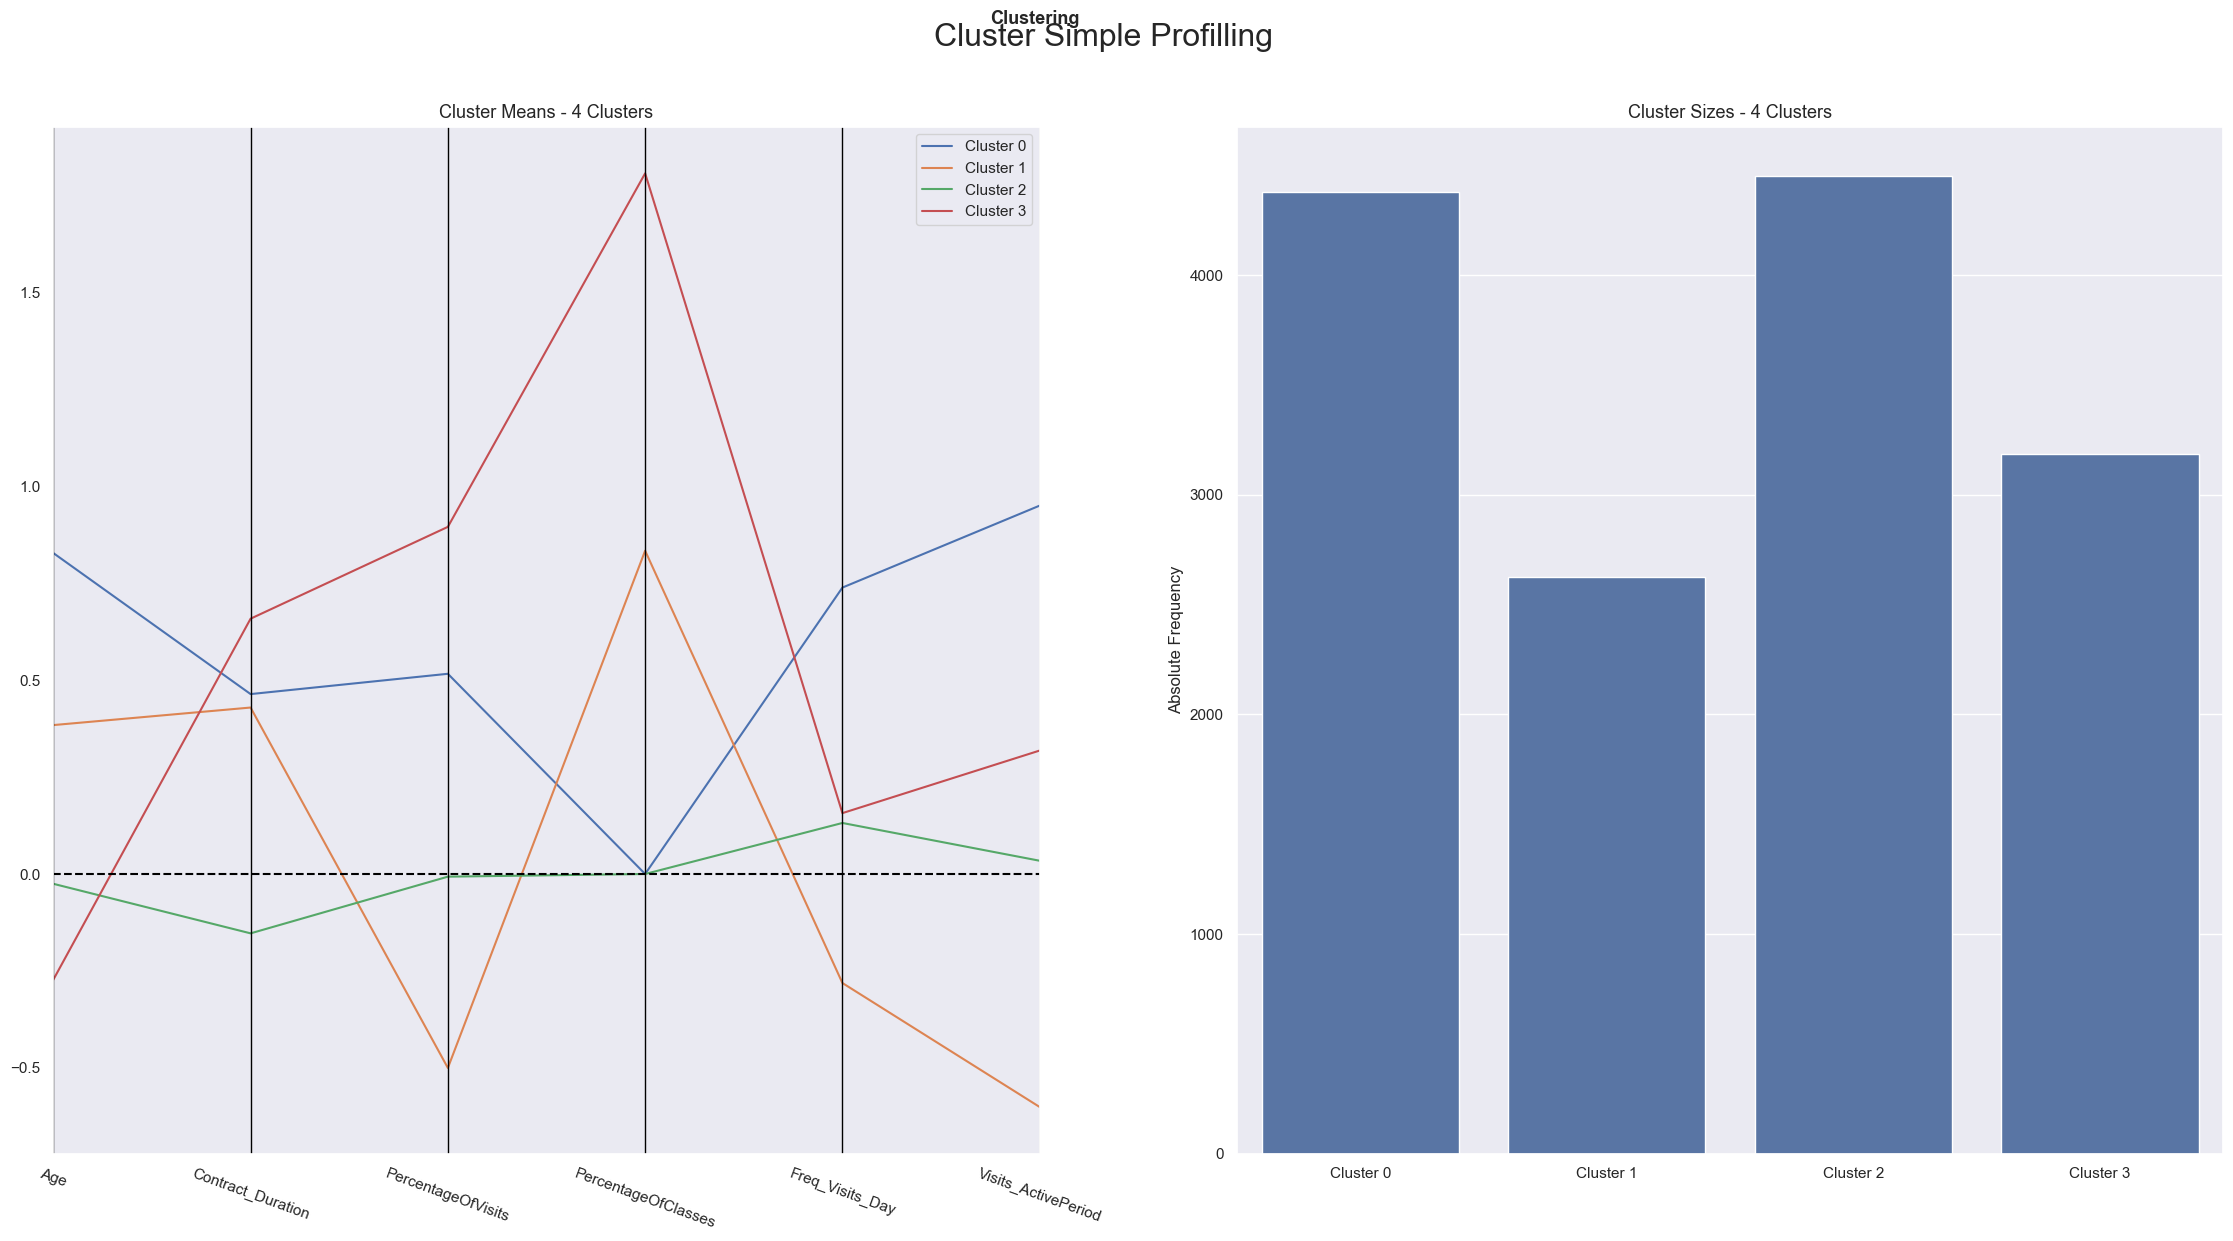

In [32]:
cluster_profiles(
    df = df_gmm[attendance_perspective + ["gmm_labels"]], 
    label_columns = ["gmm_labels"], 
    figsize = (28, 13), 
    compar_titles = ["Clustering"]
)

In [33]:
df_act= df_gmm[["gmm_labels"] + activities].groupby(["gmm_labels"]).sum()
df_compare= df_gmm[["gmm_labels"] + compare].groupby(["gmm_labels"]).sum()

In [34]:
df_act

,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities
gmm_labels,,,,,,,,
0,46.0,749.0,3352.0,79.0,1.0,421.0,129.0,3.0
1,28.0,997.0,964.0,307.0,95.0,452.0,80.0,10.0
2,27.0,408.0,3588.0,41.0,2.0,595.0,3.0,0.0
3,7.0,2090.0,628.0,363.0,245.0,127.0,151.0,15.0


Represents whaat percentage of people who do an activity belong to this group. Since our activities are very unbalanced, this way we can see what percentage of all participants belong to a certain group.

In [35]:
df_act.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities
gmm_labels,,,,,,,,
0,0.43,0.18,0.39,0.10,0.00,0.26,0.36,0.11
1,0.26,0.23,0.11,0.39,0.28,0.28,0.22,0.36
2,0.25,0.10,0.42,0.05,0.01,0.37,0.01,0.00
3,0.06,0.49,0.07,0.46,0.71,0.08,0.42,0.54


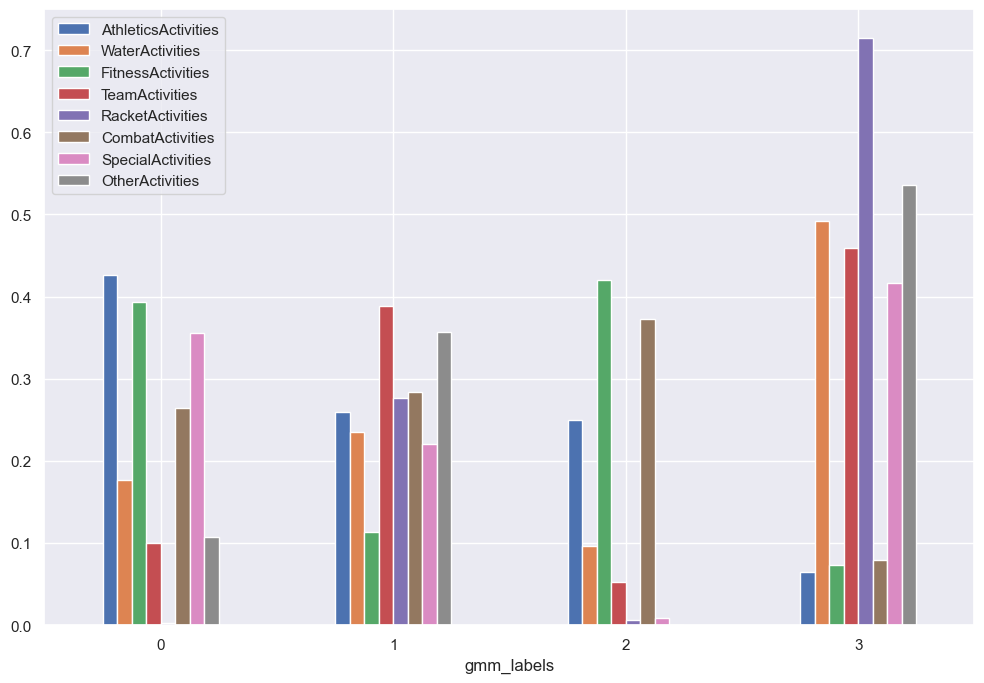

In [36]:
fig, ax = plt.subplots(figsize=(12,8))

df_act_pct = df_act.apply(lambda col: col/(col.sum()))
df_act_pct.plot(kind='bar', stacked=False, ax=ax)
plt.xticks(rotation=0)

plt.show()

In [37]:
df_compare.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,UseByTime,Dropout,Gender_Female
gmm_labels,,,
0,0.55,0.29,0.29
1,0.14,0.20,0.18
2,0.19,0.35,0.32
3,0.12,0.16,0.21


In [38]:
from sklearn.manifold import TSNE

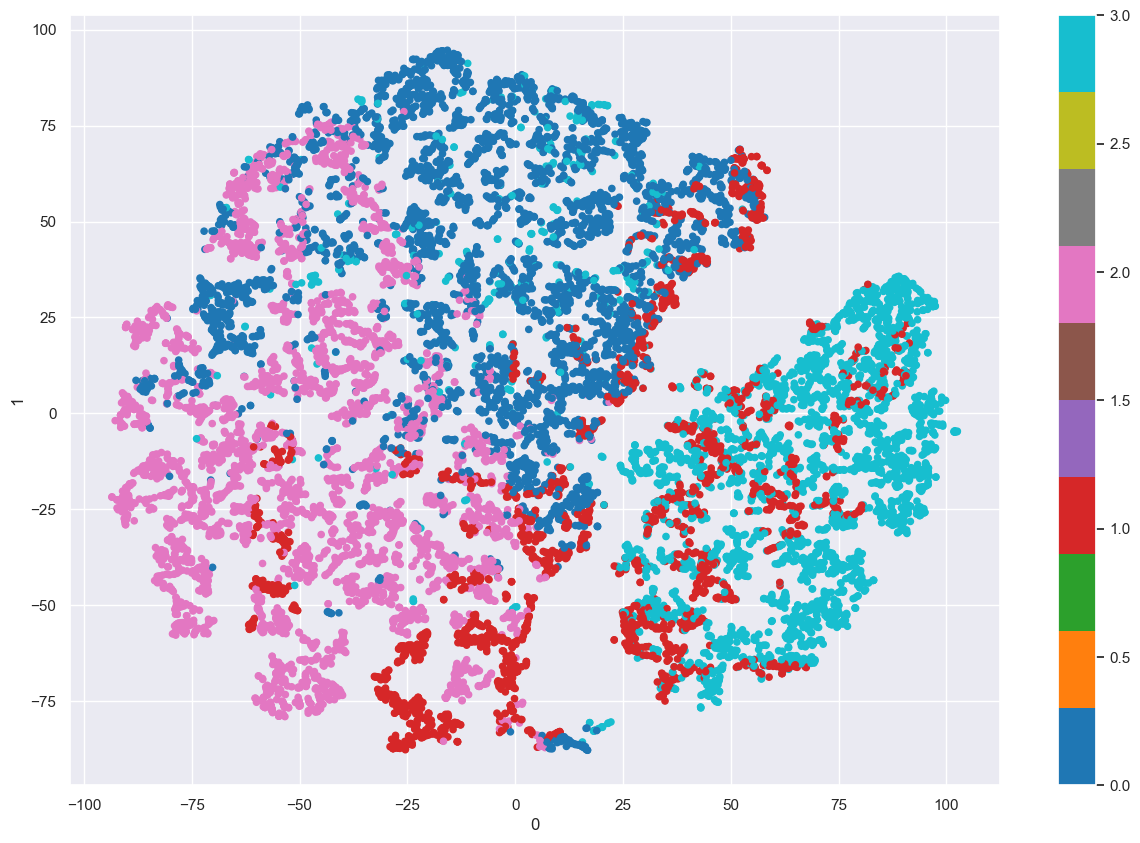

In [39]:
two_dim = TSNE(random_state=42).fit_transform(df_gmm[metric_features])
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_gmm['gmm_labels'], colormap='tab10', figsize=(15,10))
plt.show()

In [40]:
#r2 separate and dt